# Results OOD CIFAR-10 Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/ood_cifar10_first_run")

In [ ]:
get_any(results).config

_config(seed=1259, uniform_ood=False, id_dataset_name='SVHN', ood_dataset_name='CIFAR-10', initial_training_set_size=20, validation_set_size=1024, evaluation_set_size=1024, id_repetitions=1, ood_repetitions=1, add_dataset_noise=False, validation_split_random_state=0, acquisition_size=5, max_training_set=200, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, num_patience_epochs=3, max_training_epochs=60, training_batch_size=64, device='cuda', min_samples_per_epoch=5056, acquisition_function='batchbald_redux.acquisition_functions.BatchBALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel', model_optimizer_factory='batchbald_redux.resnet_models.Cifar10BayesianResnetFactory', acquisition_function_args=None, temperature=0.0)

In [ ]:
list(results.keys())

['/svhn_cifar10_ood_experiment_job_23_2021-05-21-183509.py',
 '/svhn_cifar10_ood_experiment_job_11_2021-05-21-154855.py',
 '/svhn_cifar10_ood_experiment_job_12_2021-05-21-170825.py',
 '/svhn_cifar10_ood_experiment_job_21_2021-05-21-182905.py',
 '/svhn_cifar10_ood_experiment_job_20_2021-05-21-182515.py',
 '/svhn_cifar10_ood_experiment_job_10_2021-05-21-154903.py',
 '/svhn_cifar10_ood_experiment_job_2_2021-05-21-154854.py',
 '/svhn_cifar10_ood_experiment_job_16_2021-05-21-181506.py',
 '/svhn_cifar10_ood_experiment_job_0_2021-05-21-154853.py',
 '/svhn_cifar10_ood_experiment_job_17_2021-05-21-181627.py',
 '/svhn_cifar10_ood_experiment_job_3_2021-05-21-154949.py',
 '/svhn_cifar10_ood_experiment_job_18_2021-05-21-181727.py',
 '/svhn_cifar10_ood_experiment_job_9_2021-05-21-154907.py',
 '/svhn_cifar10_ood_experiment_job_1_2021-05-21-154938.py',
 '/svhn_cifar10_ood_experiment_job_5_2021-05-21-154856.py',
 '/svhn_cifar10_ood_experiment_job_8_2021-05-21-154941.py',
 '/svhn_cifar10_ood_experiment_

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,23,1621618509
1,11,1621608535
2,12,1621613305
3,21,1621618145
4,20,1621617915
5,10,1621608543
6,2,1621608534
7,16,1621617306
8,0,1621608533
9,17,1621617387


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

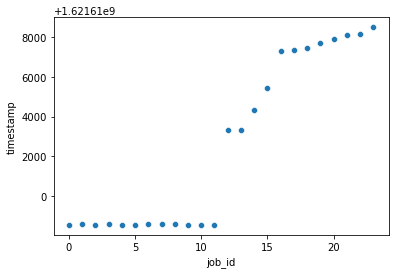

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(24, 24)

In [ ]:
results.keys()

dict_keys(['/svhn_cifar10_ood_experiment_job_23_2021-05-21-183509.py', '/svhn_cifar10_ood_experiment_job_11_2021-05-21-154855.py', '/svhn_cifar10_ood_experiment_job_12_2021-05-21-170825.py', '/svhn_cifar10_ood_experiment_job_21_2021-05-21-182905.py', '/svhn_cifar10_ood_experiment_job_20_2021-05-21-182515.py', '/svhn_cifar10_ood_experiment_job_10_2021-05-21-154903.py', '/svhn_cifar10_ood_experiment_job_2_2021-05-21-154854.py', '/svhn_cifar10_ood_experiment_job_16_2021-05-21-181506.py', '/svhn_cifar10_ood_experiment_job_0_2021-05-21-154853.py', '/svhn_cifar10_ood_experiment_job_17_2021-05-21-181627.py', '/svhn_cifar10_ood_experiment_job_3_2021-05-21-154949.py', '/svhn_cifar10_ood_experiment_job_18_2021-05-21-181727.py', '/svhn_cifar10_ood_experiment_job_9_2021-05-21-154907.py', '/svhn_cifar10_ood_experiment_job_1_2021-05-21-154938.py', '/svhn_cifar10_ood_experiment_job_5_2021-05-21-154856.py', '/svhn_cifar10_ood_experiment_job_8_2021-05-21-154941.py', '/svhn_cifar10_ood_experiment_job_19

In [ ]:
experiment_data = []

for file, result in results.items():
    try:
        if not hasattr(result, "config"):
            print(file, "empty")
            continue
        if hasattr(result, "exception"):
            print(file, "exception")
            continue
            
        config = result.config

        ood_type = "uniform_target_ood" if config.uniform_ood else "rejection_ood"
        dataset_combo = f"{config.id_dataset_name} (iD) vs {config.ood_dataset_name} (ooD)"
        
        acquisition_size = config.acquisition_size
        acquisition_function = config.acquisition_function[len("batchbald_redux.acquisition_functions.") :]
        num_pool_samples = config.num_pool_samples
        evaluation_set_size = len(result.evaluation_set_indices)
        initial_set_size = len(result.initial_training_set_indices)
                
        seed = config.seed

        if acquisition_function == "Random":
            acquisition_sizes = [5]
        else:
            acquisition_sizes = [acquisition_size]
            
        if acquisition_function == "BatchBALD":
            evaluation_set_size = 0

        # if acquisition_function == "Random":
        #     num_pool_samples = [10, 20, 50, 100]
        # else:
        num_pool_samples = [num_pool_samples]

        for nps in num_pool_samples:
            for acquisition_size in acquisition_sizes:
                if (
                    initial_set_size
                    + sum(1 if hasattr(step, "evaluation_metrics") else 0 for step in result.active_learning_steps)
                    * config.acquisition_size
                    < 150
                ):
                    print(len(result.active_learning_steps), file)
                    continue

                num_acquired_ood_samples = 0
                for i, step in enumerate(result.active_learning_steps):
                    if not hasattr(step, "evaluation_metrics"):
                        print(step)
                        break
                    if i != len(result.active_learning_steps) - 1 and not hasattr(step, "acquisition"):
                        print(file, i)
                        break

                    active_learning_acquisitions = i * config.acquisition_size
                    total_acquisitions = initial_set_size + active_learning_acquisitions
                    accuracy = step.evaluation_metrics.accuracy
                        
                    experiment_data.append(
                        dict(
                            dataset_combo=dataset_combo,
                            ood_type=ood_type,
                            acquisition_function=acquisition_function,
                            acquisition_size=acquisition_size,
                            num_pool_samples=nps,
                            total_acquisitions=total_acquisitions,
                            accuracy=accuracy,
                            evaluation_set_size=evaluation_set_size,
                            seed=seed,
                            num_acquired_ood_samples=num_acquired_ood_samples,
                            active_learning_acquisitions=active_learning_acquisitions,
                            acquired_ood_sample_ratio=num_acquired_ood_samples/total_acquisitions if total_acquisitions > 0 else 0
                        )
                    )
                    
                    if hasattr(step, "acquisition"):
                        for label in step.acquisition.labels:
                            if ood_type == "rejection_ood":
                                if label == -1:
                                    num_acquired_ood_samples+=1
                            else:
                                if all(t < 0.5 for t in label):
                                    num_acquired_ood_samples+=1
                    elif i != len(result.active_learning_steps) - 1:
                        raise Exception("'acquisition' not found in step!")
    except:
        print(file)
        raise

In [ ]:
df = pd.DataFrame.from_records(experiment_data)
df["training_set_size"] = df["total_acquisitions"] - df["num_acquired_ood_samples"]
df["smoothed_training_set_size"] = (df["total_acquisitions"] - df["num_acquired_ood_samples"])//10*10

In [ ]:
df

,dataset_combo,ood_type,acquisition_function,acquisition_size,num_pool_samples,total_acquisitions,accuracy,evaluation_set_size,seed,num_acquired_ood_samples,active_learning_acquisitions,acquired_ood_sample_ratio,training_set_size,smoothed_training_set_size
0,SVHN (iD) vs CIFAR-10 (ooD),rejection_ood,BatchBALD,5,100,20,0.111593,0,1259,0,0,0.000000,20,20
1,SVHN (iD) vs CIFAR-10 (ooD),rejection_ood,BatchBALD,5,100,25,0.125192,0,1259,0,5,0.000000,25,20
2,SVHN (iD) vs CIFAR-10 (ooD),rejection_ood,BatchBALD,5,100,30,0.128227,0,1259,2,10,0.066667,28,20
3,SVHN (iD) vs CIFAR-10 (ooD),rejection_ood,BatchBALD,5,100,35,0.112746,0,1259,4,15,0.114286,31,30
4,SVHN (iD) vs CIFAR-10 (ooD),rejection_ood,BatchBALD,5,100,40,0.137139,0,1259,5,20,0.125000,35,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,SVHN (iD) vs CIFAR-10 (ooD),uniform_target_ood,BatchBALD,5,100,180,0.241933,0,1248,8,160,0.044444,172,170
1056,SVHN (iD) vs CIFAR-10 (ooD),uniform_target_ood,BatchBALD,5,100,185,0.229487,0,1248,8,165,0.043243,177,170
1057,SVHN (iD) vs CIFAR-10 (ooD),uniform_target_ood,BatchBALD,5,100,190,0.234404,0,1248,8,170,0.042105,182,180
1058,SVHN (iD) vs CIFAR-10 (ooD),uniform_target_ood,BatchBALD,5,100,195,0.234634,0,1248,8,175,0.041026,187,180


In [ ]:
df.acquisition_size.unique()

array([5])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("active_learning_acquisitions == 0").groupby(["dataset_combo", "ood_type", "acquisition_size", "evaluation_set_size"])["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

dataset_combo                ood_type            acquisition_size  evaluation_set_size  acquisition_function
CIFAR-10 (iD) vs SVHN (ooD)  rejection_ood       5                 0                    BatchBALD               3
                                                                   1020                 BatchEvalBALD           3
                             uniform_target_ood  5                 0                    BatchBALD               3
                                                                   1020                 BatchEvalBALD           3
SVHN (iD) vs CIFAR-10 (ooD)  rejection_ood       5                 0                    BatchBALD               3
                                                                   1020                 BatchEvalBALD           3
                             uniform_target_ood  5                 0                    BatchBALD               3
                                                                   1020                 Batch

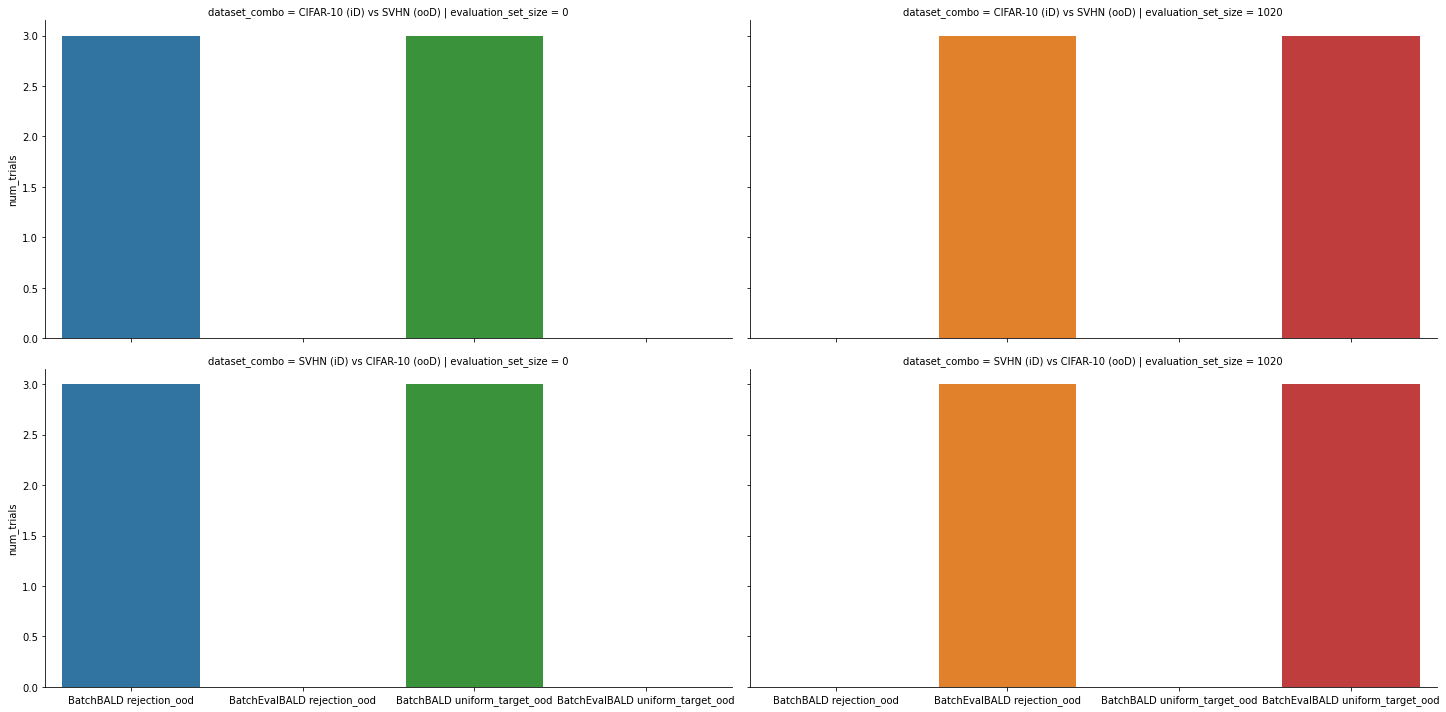

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x=num_trials_by_acquisition_size_and_function["acquisition_function"] + " " + num_trials_by_acquisition_size_and_function["ood_type"],
    col="evaluation_set_size",
    row="dataset_combo",
    aspect=2,
)
grd.fig.patch.set_alpha(1)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

# MatPlotLib style and settings (that also affect PlotNine)

rc("text", usetex=False)
rc(
    "text.latex",
    preamble=r"""
\usepackage{bbm}
\usepackage{amsmath}
\usepackage{amsfonts}
""",
)

In [ ]:
sns.set_style("whitegrid")
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
def plt_save(grd, output_path, **kwargs):
    # plt.style.use("seaborn-colorblind")
    grd.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0, **kwargs)

In [ ]:
dashes = {0: "", 1020: ""}

In [ ]:
nice_acquisition_function_map = {
    "Random": "Uniform",
    "BALD": "BALD",
    "BatchEvalBALD": "BatchEPIG-BALD",
    "BatchBALD": "BatchBALD",
}


def to_nice_acquisition_function(n):
    return nice_acquisition_function_map[n]

In [ ]:
df["Acquisition Function"] = df.acquisition_function.map(nice_acquisition_function_map)
df["nice_ood_type"] = df.ood_type.map(dict(rejection_ood="OoD Rejection", uniform_target_ood="OoD Exposure"))
df["Evaluation Set Size"] = df.evaluation_set_size

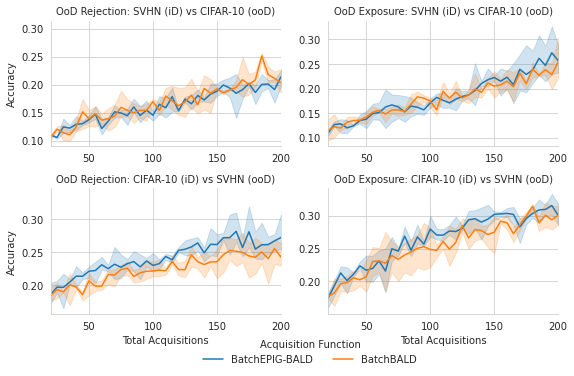

In [ ]:
grd = sns.relplot(
    x="total_acquisitions",
    y="accuracy",
    col="nice_ood_type",
    #style="evaluation_set_size",
    row="dataset_combo",
    hue="Acquisition Function",
    data=df,
    kind="line",
    height=2.5,
    aspect=1.61,
    #dashes=dashes,
    #size=sizes,
    facet_kws=dict(sharey=False,sharex=False),
    hue_order=list(
        map(
            to_nice_acquisition_function,
            [
                "BatchEvalBALD",
                "BatchBALD",                
            ],
        )
    ),
)

#grd.fig.patch.set_alpha(1)
grd.set_xlabels("Total Acquisitions")
grd.set_ylabels("Accuracy")
grd.set_titles("{col_name}: {row_name}")
grd.tight_layout()

for i in range(2):
    for j in range(2):
        grd.axes[i][j].set_xlim(20,200)

handles, labels = grd.axes[0][0].get_legend_handles_labels()
grd._legend.remove()
grd.fig.legend(handles, labels, ncol=2, loc='lower center', title="Acquisition Function",
                bbox_to_anchor=(0.45, -0.05), frameon=False)

In [ ]:
plt_save(grd, "plots/ood_cifar10_and_svhn.pdf")

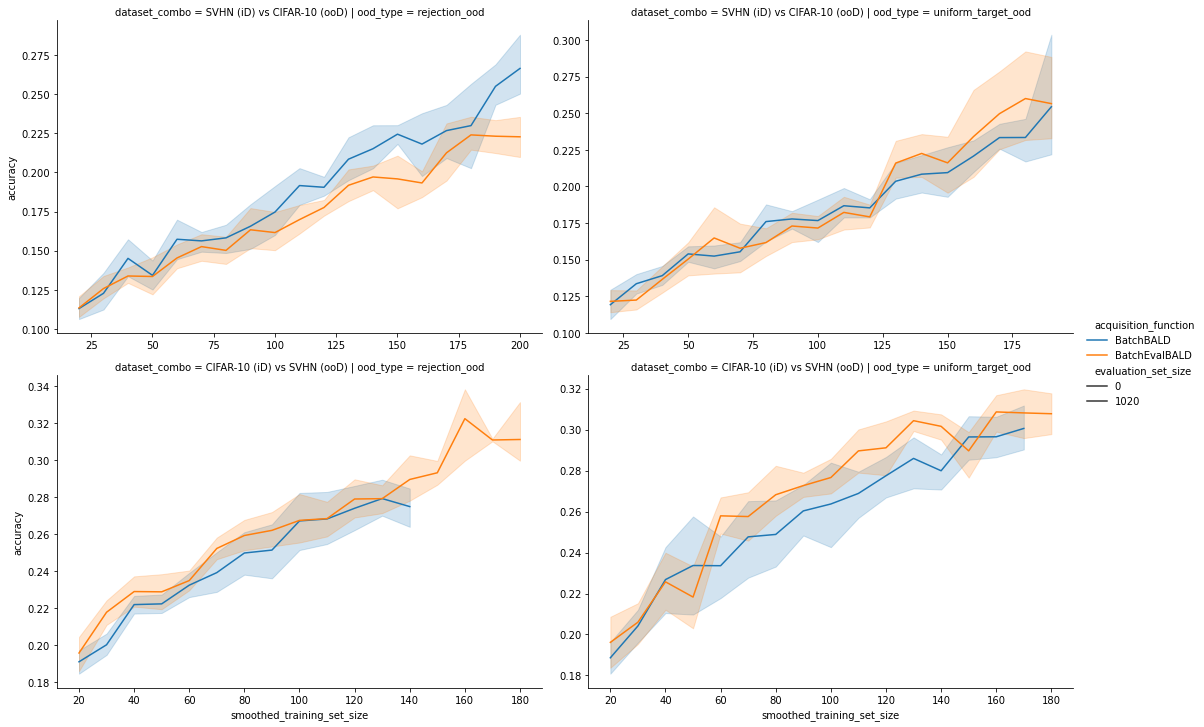

In [ ]:
grd = sns.relplot(
    x="smoothed_training_set_size",
    y="accuracy",
    col="ood_type",
    style="evaluation_set_size",
    row="dataset_combo",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
    aspect=1.5,
    dashes=dashes,
    facet_kws=dict(sharey=False,sharex=False)
)

grd.fig.patch.set_alpha(1)

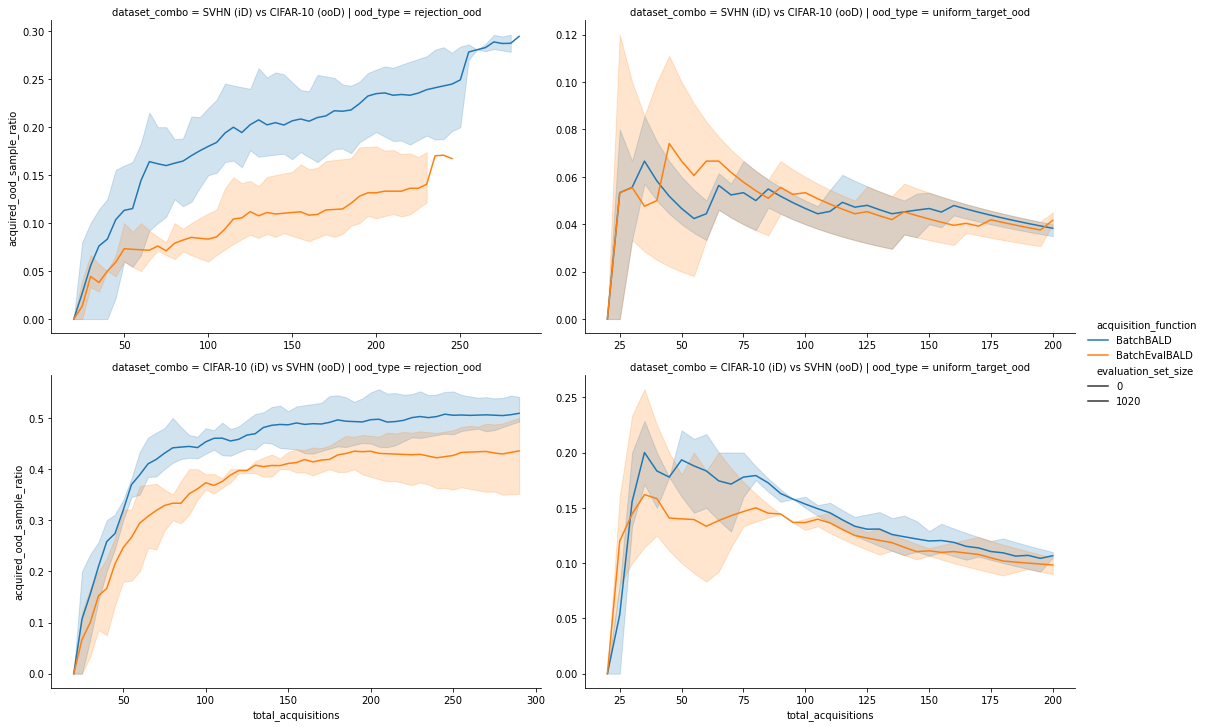

In [ ]:
grd = sns.relplot(
    x="total_acquisitions",
    y="acquired_ood_sample_ratio",
    col="ood_type",
    style="evaluation_set_size",
    row="dataset_combo",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
    aspect=1.5,
    dashes=dashes,
    facet_kws=dict(sharey=False,sharex=False)
)

grd.fig.patch.set_alpha(1)

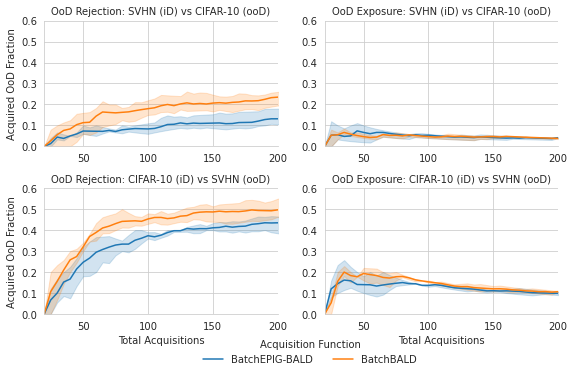

In [ ]:
grd = sns.relplot(
    x="total_acquisitions",
    y="acquired_ood_sample_ratio",
    col="nice_ood_type",
    #style="Evaluation Set Size",
    row="dataset_combo",
    hue="Acquisition Function",
    data=df, #.sample(frac=0.01),
    kind="line",
    height=2.5,
    aspect=1.61,
    #dashes=dashes,
    facet_kws=dict(sharey=False,sharex=False),
    hue_order=list(
        map(
            to_nice_acquisition_function,
            [
                "BatchEvalBALD",
                "BatchBALD",                
            ],
        )
    ),
)

#grd.fig.patch.set_alpha(1)
grd.set_xlabels("Total Acquisitions")
grd.set_ylabels("Acquired OoD Fraction")
grd.set_titles("{col_name}: {row_name}")
grd.tight_layout()

for i in range(2):
    for j in range(2):
        grd.axes[i][j].set_ylim(0,0.6)
        grd.axes[i][j].set_xlim(20,200)

handles, labels = grd.axes[0][0].get_legend_handles_labels()
grd._legend.remove()
grd.fig.legend(handles, labels, ncol=2, loc='lower center', title="Acquisition Function",
                bbox_to_anchor=(0.45, -0.05), frameon=False)

In [ ]:
plt_save(grd, "plots/ood_cifar10_and_svhn_ratio.pdf")

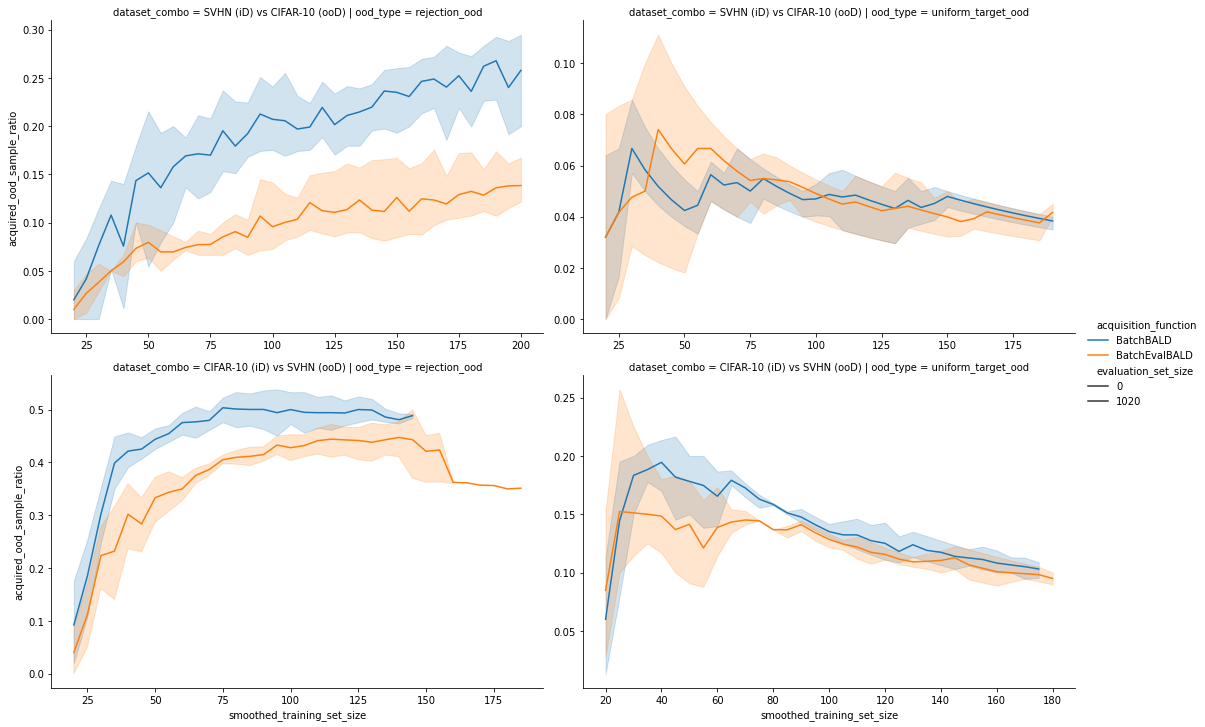

In [ ]:
grd = sns.relplot(
    x="smoothed_training_set_size",
    y="acquired_ood_sample_ratio",
    col="ood_type",
    style="evaluation_set_size",
    row="dataset_combo",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
    aspect=1.5,
    dashes=dashes,
    facet_kws=dict(sharey=False,sharex=False)
)

grd.fig.patch.set_alpha(1)

In [ ]:
import qgrid

group_fields = ["dataset_combo", "ood_type", "evaluation_set_size", "acquisition_function"] 

df["max_accuracy"] = df.groupby(["seed"] + group_fields).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=group_fields + ["seed", "max_accuracy"])
#qgrid.show_grid(df_max_accuracy)
df_max_accuracy

,dataset_combo,ood_type,acquisition_function,acquisition_size,num_pool_samples,total_acquisitions,accuracy,evaluation_set_size,seed,num_acquired_ood_samples,active_learning_acquisitions,acquired_ood_sample_ratio,training_set_size,smoothed_training_set_size,max_accuracy
0,FastFashionMNIST (iD) vs FastMNIST (ooD),rejection_ood,BatchBALD,5,100,20,0.6171,0,1296,0,0,0.000000,20,20,0.6171
23,FastFashionMNIST (iD) vs FastMNIST (ooD),rejection_ood,BatchBALD,5,100,135,0.6220,0,1296,106,115,0.785185,29,25,0.6220
28,FastFashionMNIST (iD) vs FastMNIST (ooD),rejection_ood,BatchBALD,5,100,160,0.6249,0,1296,130,140,0.812500,30,30,0.6249
38,FastFashionMNIST (iD) vs FastMNIST (ooD),rejection_ood,BatchBALD,5,100,210,0.6318,0,1296,180,190,0.857143,30,30,0.6318
55,FastMNIST (iD) vs FastFashionMNIST (ooD),uniform_target_ood,BatchEvalBALD,5,100,20,0.6635,250,1306,0,0,0.000000,20,20,0.6635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286,FastMNIST (iD) vs FastFashionMNIST (ooD),rejection_ood,BatchEvalBALD,5,100,160,0.9307,10,1236,14,140,0.087500,146,145,0.9307
3289,FastMNIST (iD) vs FastFashionMNIST (ooD),rejection_ood,BatchEvalBALD,5,100,175,0.9403,10,1236,16,155,0.091429,159,155,0.9403
3292,FastMNIST (iD) vs FastFashionMNIST (ooD),rejection_ood,BatchEvalBALD,5,100,190,0.9425,10,1236,19,170,0.100000,171,170,0.9425
3294,FastMNIST (iD) vs FastFashionMNIST (ooD),rejection_ood,BatchEvalBALD,5,100,200,0.9487,10,1236,21,180,0.105000,179,175,0.9487


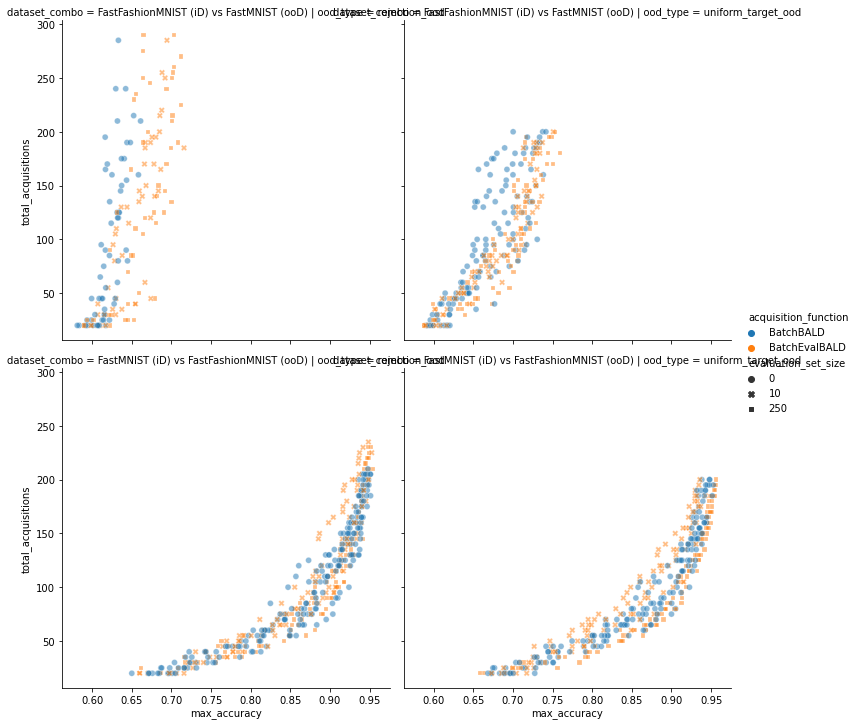

In [ ]:
grd = sns.relplot(
    y="total_acquisitions",
    x="max_accuracy",
    col="ood_type",
    row="dataset_combo",
    hue="acquisition_function",
    style="evaluation_set_size",
    data=df_max_accuracy[df_max_accuracy.acquisition_function != "random"],
    kind="scatter",
    height=5,
    alpha=0.5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[(df.accuracy >= 0.90) & (df.acquisition_function != "random")].groupby(group_fields).first()

In [ ]:
df3 = df2.groupby(group_fields).total_acquisitions.quantile([0.25, 0.5, 0.75])
df3

dataset_combo                             ood_type            evaluation_set_size  acquisition_function      
FastMNIST (iD) vs FastFashionMNIST (ooD)  rejection_ood       0                    BatchBALD             0.25    135.0
                                                                                                         0.50    135.0
                                                                                                         0.75    135.0
                                                              10                   BatchEvalBALD         0.25     95.0
                                                                                                         0.50     95.0
                                                                                                         0.75     95.0
                                                              250                  BatchEvalBALD         0.25    105.0
                                                         

In [ ]:
df3.unstack()

0.25  \
dataset_combo                            ood_type           evaluation_set_size acquisition_function          
FastMNIST (iD) vs FastFashionMNIST (ooD) rejection_ood      0                   BatchBALD             135.0   
                                                            10                  BatchEvalBALD          95.0   
                                                            250                 BatchEvalBALD         105.0   
                                         uniform_target_ood 0                   BatchBALD             100.0   
                                                            10                  BatchEvalBALD         125.0   
                                                            250                 BatchEvalBALD         105.0   

                                                                                                       0.50  \
dataset_combo                            ood_type           evaluation_set_size acquisition_function          
FastMNIST (iD) vs FastFashionMNIST (ooD) rejection_ood      0                   BatchBALD             135.0   
                                                            10                  BatchEvalBALD          95.0   
                                                            250                 BatchEvalBALD         105.0   
                                         uniform_target_ood 0                   BatchBALD             100.0   
                                                            10                  BatchEvalBALD         125.0   
                                                            250                 BatchEvalBALD         105.0   

                                                                                                       0.75  
dataset_combo                            ood_type           evaluation_set_size acquisition_function         
FastMNIST (iD) vs FastFashionMNIST (ooD) rejection_ood      0                   BatchBALD             135.0  
                                                            10                  BatchEvalBALD          95.0  
                                                            250                 BatchEvalBALD         105.0  
                                         uniform_target_ood 0                   BatchBALD             100.0  
                                                            10                  BatchEvalBALD         125.0  
                                                            250                 BatchEvalBALD         105.0

In [ ]:
df2 = df[(df.accuracy >= 0.70) & (df.dataset_combo != "FastMNIST (iD) vs FastFashionMNIST (ooD)")].groupby(group_fields).first()
df3 = df2.groupby(group_fields).total_acquisitions.quantile([0.25, 0.5, 0.75])
df3.unstack()

0.25  \
dataset_combo                            ood_type           evaluation_set_size acquisition_function          
FastFashionMNIST (iD) vs FastMNIST (ooD) rejection_ood      10                  BatchEvalBALD         185.0   
                                                            250                 BatchEvalBALD         250.0   
                                         uniform_target_ood 0                   BatchBALD             100.0   
                                                            10                  BatchEvalBALD         110.0   
                                                            250                 BatchEvalBALD         145.0   

                                                                                                       0.50  \
dataset_combo                            ood_type           evaluation_set_size acquisition_function          
FastFashionMNIST (iD) vs FastMNIST (ooD) rejection_ood      10                  BatchEvalBALD         185.0   
                                                            250                 BatchEvalBALD         250.0   
                                         uniform_target_ood 0                   BatchBALD             100.0   
                                                            10                  BatchEvalBALD         110.0   
                                                            250                 BatchEvalBALD         145.0   

                                                                                                       0.75  
dataset_combo                            ood_type           evaluation_set_size acquisition_function         
FastFashionMNIST (iD) vs FastMNIST (ooD) rejection_ood      10                  BatchEvalBALD         185.0  
                                                            250                 BatchEvalBALD         250.0  
                                         uniform_target_ood 0                   BatchBALD             100.0  
                                                            10                  BatchEvalBALD         110.0  
                                                            250                 BatchEvalBALD         145.0